## Logistic Classifier

In this notebook, I will try to build a logistic regression model that classifies the images in CIFAR-10 dataset, which contains 60,000 images that belong to 10 distinct categories. I am planning to build 2 different variants of the logistic regression:
1. **OvA Logistic Regression:** In this model, a binary classifier model will be built for each of the 10 classes.
2. **Multinomial Logistic Regression:** This model will classify images into 10 categories with only 1 model.

In [1]:
from tensorflow import keras

### Import Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


### EDA

In [32]:
def plot_sample(img):
  plt.figure(figsize=(10,1))
  plt.imshow(img)
  plt.plot()

Label is 6


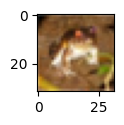

In [33]:
# sample image

plot_sample(x_train[0])
print("Label is", y_train[0][0])

#### Class Distribution

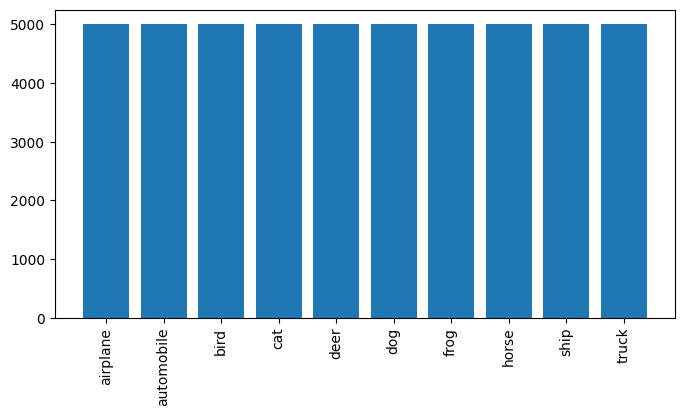

In [42]:
# class distribution
classes = ["airplane",
          "automobile",
          "bird",
          "cat",
          "deer",
          "dog",
          "frog",
          "horse",
          "ship",
          "truck"]

class_dist = {i:0 for i in classes}
for i in y_train:
  class_dist[classes[i[0]]] += 1

plt.figure(figsize=(8,4))
plt.bar(class_dist.keys(), class_dist.values())
plt.xticks(rotation=90)
plt.plot();

Classes are equally distributed, so we're good.

#### Samples from different classes

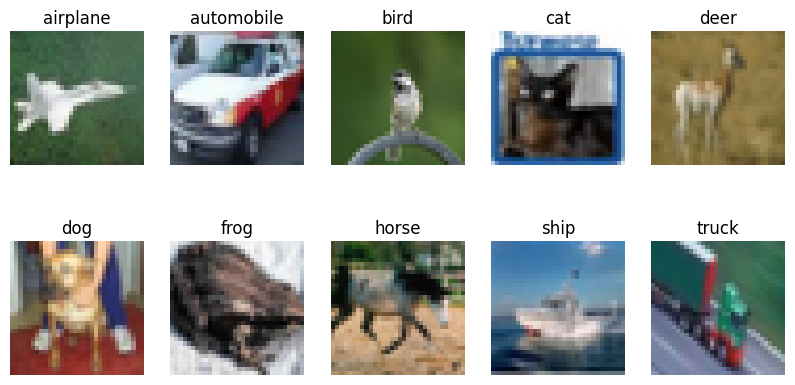

In [44]:
# samples from each class
samples = {i: None for i in classes}
for i in range(50, len(y_train)):
  if samples[classes[y_train[i][0]]] is None:
    samples[classes[y_train[i][0]]] = x_train[i]
  else:
    continue
  
plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(samples[classes[i]])
  plt.title(classes[i])
  plt.axis("off")

#### Samples from same class

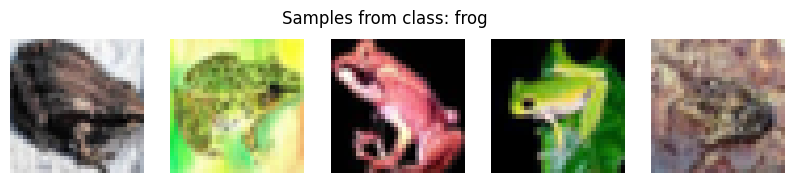

In [46]:
import matplotlib.pyplot as plt

# different samples from one class
def plot_samples(class_name):
    samples = []
    for i in range(50, len(y_train)):
        if len(samples) == 5:
            break
        if classes[y_train[i][0]] == class_name:
            samples.append(x_train[i])
    plt.figure(figsize=(10, 2))
    plt.suptitle(f'Samples from class: {class_name}', fontsize=12)
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(samples[i])
        plt.axis("off")

plot_samples("frog")

### Scale and Flatten

In [48]:
# standardize the data
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

In [49]:
# flatten the data
x_train_flat = x_train_scaled.reshape(-1, 32*32*3)
x_test_flat = x_test_scaled.reshape(-1, 32*32*3)

In [50]:
print(x_train_flat.shape)
print(x_test_flat.shape)

(50000, 3072)
(10000, 3072)


### Logistic Regression Model 1: OvA
10 distinct binary classifiers will be built. I pick one class as my target class and the model will predict this class as 1, and for the rest of the classes the model will give the output 0. So, the problem is broken down into seperate binary classification problems. This model is also known as OvA (One vs. All) or OvR (One vs. Rest).

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [87]:
logistic_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# train the model
logistic_model.fit(x_train_flat, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

Without dimensionality reduction, it took 13m 49s to run.

In [89]:
y_train_pred = logistic_model.predict(x_train_flat)
y_test_pred = logistic_model.predict(x_test_flat)

In [91]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Model Accuracy on Training Data: {accuracy * 100:.2f}%")
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

Model Accuracy on Training Data: 48.78%
Model Accuracy on Test Data: 39.13%


In [92]:
# detailed classification report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.48      0.47      1000
           1       0.45      0.46      0.46      1000
           2       0.30      0.27      0.29      1000
           3       0.27      0.23      0.25      1000
           4       0.34      0.28      0.30      1000
           5       0.31      0.32      0.32      1000
           6       0.39      0.46      0.42      1000
           7       0.45      0.43      0.44      1000
           8       0.48      0.53      0.51      1000
           9       0.42      0.45      0.43      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.39     10000
weighted avg       0.39      0.39      0.39     10000



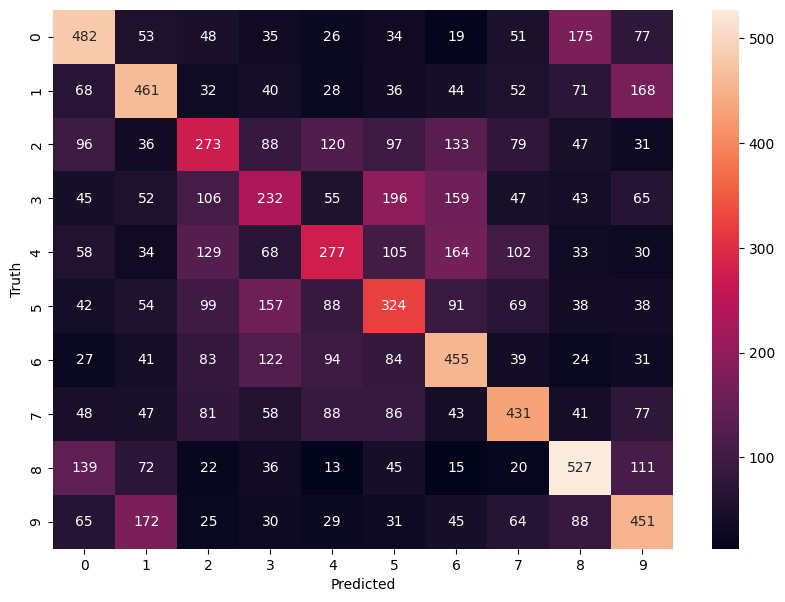

In [93]:
import seaborn as sn

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

#### Dimensionality Reduction with PCA

In [94]:
from sklearn.decomposition import PCA

# reduce the dimensionality from 3072 to 300
pca = PCA(n_components=300)
x_reduced = pca.fit_transform(x_train_flat)

In [95]:
logistic_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# train the model
logistic_model.fit(x_reduced, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

After reducing to 300, training duration reduced to 16.7s.

In [98]:
# also reduce the test data
x_test_reduced = pca.transform(x_test_flat)

In [99]:
y_train_pred = logistic_model.predict(x_reduced)
y_test_pred = logistic_model.predict(x_test_reduced)

In [100]:
# accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Model Accuracy on Training Data: {accuracy * 100:.2f}%")
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

Model Accuracy on Training Data: 43.26%
Model Accuracy on Test Data: 40.94%


We have a small improvement of %4.63. Moreover, we have reduced the overfitting.

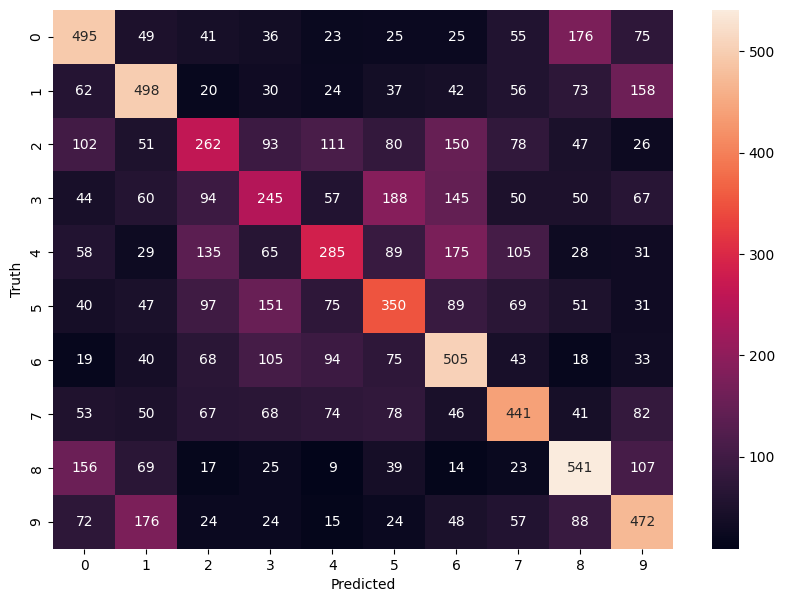

In [104]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

#### Dimensionality Reduction with AutoEncoder

In [111]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Dense, Lambda
from tensorflow.keras.losses import MeanSquaredError

class AutoEncoder(Model):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = tf.keras.Sequential([
            Flatten(),
            Dense(self.encoding_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            Dense(32*32*3, activation='sigmoid'),
            Reshape((32, 32, 3))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [112]:
autoencoder = AutoEncoder(encoding_dim=256)
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())
autoencoder.fit(x_train_scaled, x_train_scaled, epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0331
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 0.0164
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.0136
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.0130
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.0129
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 0.0129
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.0128
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - loss: 0.0128
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.0128
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.0127


In [113]:
x_encoded_train = autoencoder.encoder(x_train_scaled).numpy()
print(x_encoded_train.shape)

(50000, 256)


In [114]:
logistic_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# train the model
logistic_model.fit(x_encoded_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [115]:
x_encoded_test = autoencoder.encoder(x_test_scaled).numpy()
print(x_encoded_test.shape)

(10000, 256)


In [117]:
y_train_pred = logistic_model.predict(x_encoded_train)
y_test_pred = logistic_model.predict(x_encoded_test)

In [118]:
# accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Model Accuracy on Training Data: {accuracy * 100:.2f}%")
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

Model Accuracy on Training Data: 37.20%
Model Accuracy on Test Data: 37.29%


With autoencoder, accuracy score is not as good as PCA. Although we have a big underfitting problem, the overfitting is really low in this model.

### Logistic Regression 2: Multinomial
A logistic classifier will be built, and unlike the preceding model, this model is not a binary classifier, it has 10 different outputs.

In [119]:
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

logistic_model.fit(x_train_flat, y_train)

c:\Users\ftihs\Desktop\DeepLearning\CIFAR10_Classification\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ftihs\Desktop\DeepLearning\CIFAR10_Classification\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\ftihs\Desktop\DeepLearning\CIFAR10_Classification\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pleas

LogisticRegression(max_iter=1000, multi_class='multinomial')

Without dimensionality reduction, it takes 7m 17s. It is very long, let's see the accuracy.

In [120]:
y_train_pred = logistic_model.predict(x_train_flat)
y_test_pred = logistic_model.predict(x_test_flat)

In [121]:
# accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Model Accuracy on Training Data: {accuracy * 100:.2f}%")
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

Model Accuracy on Training Data: 48.34%
Model Accuracy on Test Data: 39.24%


Similar accuracy score with the other model without the dimensionality reduction, although this model has slightly higher overfitting.

In [123]:
# classification report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.47      0.45      1000
           1       0.46      0.46      0.46      1000
           2       0.31      0.29      0.30      1000
           3       0.26      0.24      0.25      1000
           4       0.33      0.28      0.30      1000
           5       0.32      0.33      0.33      1000
           6       0.40      0.46      0.43      1000
           7       0.45      0.43      0.44      1000
           8       0.49      0.53      0.51      1000
           9       0.42      0.45      0.43      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.39     10000
weighted avg       0.39      0.39      0.39     10000



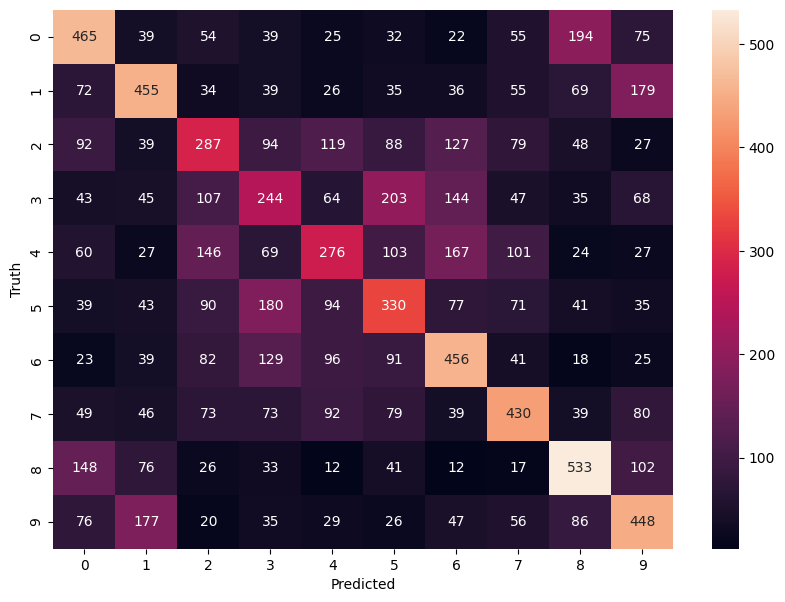

In [125]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

#### Try Dimensionality Reduction with PCA

In [126]:
from sklearn.decomposition import PCA

# reduce the dimensionality from 3072 to 300
pca = PCA(n_components=300)
x_reduced = pca.fit_transform(x_train_flat)

In [127]:
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# train the model
logistic_model.fit(x_reduced, y_train)

c:\Users\ftihs\Desktop\DeepLearning\CIFAR10_Classification\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ftihs\Desktop\DeepLearning\CIFAR10_Classification\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

With dim. reduction with PCA, we have 11s of training duration, let's see the accuracy.

In [128]:
# also reduce the test data
x_test_reduced = pca.transform(x_test_flat)

In [129]:
y_train_pred = logistic_model.predict(x_reduced)
y_test_pred = logistic_model.predict(x_test_reduced)

In [130]:
# accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Model Accuracy on Training Data: {accuracy * 100:.2f}%")
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

Model Accuracy on Training Data: 43.52%
Model Accuracy on Test Data: 40.71%


We have very similar scores with the first model. The improvement on accuracy is the same along with the reduction on overfitting.

#### Dimensionality Reduction with AutoEncoder
Since the data is the same, I will not write another encoder. (It takes so much time in my slow ass PC)

In [131]:
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# train the model
logistic_model.fit(x_encoded_train, y_train)

c:\Users\ftihs\Desktop\DeepLearning\CIFAR10_Classification\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ftihs\Desktop\DeepLearning\CIFAR10_Classification\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [132]:
y_train_pred = logistic_model.predict(x_encoded_train)
y_test_pred = logistic_model.predict(x_encoded_test)

In [133]:
# accuracy score
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Model Accuracy on Training Data: {accuracy * 100:.2f}%")
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

Model Accuracy on Training Data: 37.28%
Model Accuracy on Test Data: 37.36%


Again, we have very similar results with the previous model's results, i.e. low overfitting and high underfitting.

## Conclusion

| Model Type                     | Preprocessing      | Training Accuracy | Test Accuracy | Time Taken          |
|--------------------------------|-------------------|------------------|--------------|--------------------|
| OvA Logistic Regression        | -            | 48.78%            | 39.13%        | 13m 49s             |
| OvA Logistic Regression        | PCA(300)          | 43.26%            | **40.94%**        | 31s + 16s            |
| OvA Logistic Regression        | Autoencoder(256)  | 37.20%            | 37.29%        | 4m 44s + 15s         |
| Multinomial Logistic Regression | -            | 48.34%            | 39.24%        | 7m 17s              |
| Multinomial Logistic Regression | PCA(300)          | 43.52%            | 40.71%        | 31s + 11s            |
| Multinomial Logistic Regression | Autoencoder(256)  | 37.28%            | 37.36%        | 4m 44s + 42s         |


#### 1. **Overall Performance Observations:**
   - **Normal (No Dimensionality Reduction)**  
     - Both OvA and Multinomial Logistic Regression models achieve the highest training accuracy (~48%) but generalize poorly, with test accuracy around 39%.  
     - This suggests possible overfitting to the training data when using all features.  
     - The time taken is also the longest in this case, indicating higher computational complexity when using the full feature set.

   - **PCA (300 Components)**  
     - A significant reduction in training time is observed compared to the normal model.  
     - Training accuracy is slightly lower (~43%), but test accuracy improves slightly (around 41%).  
     - This suggests that PCA helps in reducing overfitting and improving generalization by capturing the most important feature variations.

   - **Autoencoder (256 Units)**  
     - This method results in the lowest accuracy across both training and test data (~37%).  
     - However, the generalization gap between training and test accuracy is minimal, indicating better generalization than the normal model.  
     - Training time is shorter compared to the normal model but higher compared to PCA due to the neural network training process.
<br />

#### 2. **Comparison Between OvA and Multinomial Logistic Regression:**
   - Both models yield very similar results in terms of accuracy, with only minor differences.  
   - Multinomial Logistic Regression seems to have a slightly better test accuracy for the normal and autoencoder-based features, while OvA performs slightly better with PCA, but these improvements are not significant, it is mostly a very small fraction of a percent.  
   - Time taken for Multinomial Logistic Regression is generally shorter, making it a more efficient choice.
<br />

#### 3. **Impact of Dimensionality Reduction Techniques:**
   - **PCA (300)** appears to be the most balanced choice, offering a good trade-off between accuracy and computational efficiency.  
   - **Autoencoder (256)** struggles to match the performance of PCA, possibly due to the complexity of feature representation learned by the network. It might require more tuning (e.g., deeper networks, different latent dimensions).
<br />

#### 4. **Future Work:**
   - A comprehensive hyperparameter tuning can be done to these models. Although, I did some tuning myself on max iterations of the regression model and encoding dimensions of the Autoencoder (not included in the notebook), a comprehensive tuning would involve tuning the other parameters of the model, too. Also, I did not do any tuning for the PCA and Autoencoder Reducers' parameters. The reason why my models work poorly might stem from the poor choice of hyperparameters.